### Liberaries

In [1]:
import os
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adadelta
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import seaborn as sns
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

### Hash table to convert labeled numbers into user names "Thanks to Shirouk for creating it"

In [28]:
user_dict = {
    0: 'amr',
    1: 'abdelrahman saeed',
    2: 'yousif adham', 
    3: 'rawada yousry', 
    4: 'saeed elsayed', 
    5: 'mariam mogahed', 
    6: 'mariam turky', 
    7: 'doha eid', 
    8: 'nada ahmed', 
    9: 'bassant medhat', 
    10: 'nevin', 
    11: 'dina hossam',
    12: 'mahmoud hamdy',
    13: 'yousif shaban',
    14: 'mariam hossam',
    15: 'Abram',
    16: 'maha fathy',
    17: 'mariam mohamed',
    18: 'sherif',
    19: 'yousif essam',
    20: 'yousr ashraf',
    21: 'mai khaled',
    22: 'omer anwar',
    23: 'ibraheem mohamed',
    24: 'habiba fathallah',
    25: 'mohamed sayed zaki',
    26: 'mahmoud rabia',
    27: 'amira',
    28: 'abdelrahman yasser',
    29: 'mahmoud zakaria',
    30: 'mohamed esmail',
    31: 'amr mohamed ',
    32: 'ghofran',
    33: 'kamel',
    34: 'Belal',
    35: 'Ahmed elsarta',
    36: 'Aisha',
    37: 'rawan ghanem',
    38: 'hania',
    39: 'adham',
    40: 'ahmed hassan',
    41: 'aya sameh',
    42: 'ehab',
    43: 'esraa',
    44: 'mayar fayez',
    45: 'hagar',
    46: 'misara',
    47: 'mariam monir',
    48: 'mayar ehab',
    49: 'mazen',
    50: 'mohamed',
    51: 'salman',
    52: 'mariam wael',
    53: 'beshara',
    54: 'mohamed salah',
    55: 'ezzat',
    56: 'ahmed maher',
    57: 'diaa',
    58: 'dina mostafa',
    59: 'rawan rashed',
    60: 'ereni',
    61: 'mohamed naser',
    62: 'rahma',
    63: 'yousif',
    64: 'kareman',
    65: 'naira',
    66: 'mickel',
    67: 'sara amgad',
    68: 'yasmin',
    69: 'yehia'
}

### Dataset Path

In [2]:
base_path = '/kaggle/input/arabic-signature70/arabic_signature'

### Dataset Reading and Preprocessing

In [3]:
data = []
labels = []

# for preprocessing and resizing
new_width = 200
new_height = 200

folders = sorted(os.listdir(base_path))
num_classes = len(folders)

for i, folder in enumerate(folders):

    folder_path = os.path.join(base_path, folder)
    images = sorted(os.listdir(folder_path))

    for image_name in images:

        # Reading the image
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)

        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize the image
        resized_image = cv2.resize(gray_image, (new_width, new_height))

        # Append the preprocessed image and its label
        data.append(resized_image)
        labels.append(i)

# Convert lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Reshape the data for CNN input (add channel dimension for grayscale)
data = data.reshape(-1, new_width, new_height, 1)

# Convert labels to one-hot encoded format
labels = to_categorical(labels, num_classes=num_classes)

### Splitting dataset to train and test sets

In [4]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

### Exploring the dataset

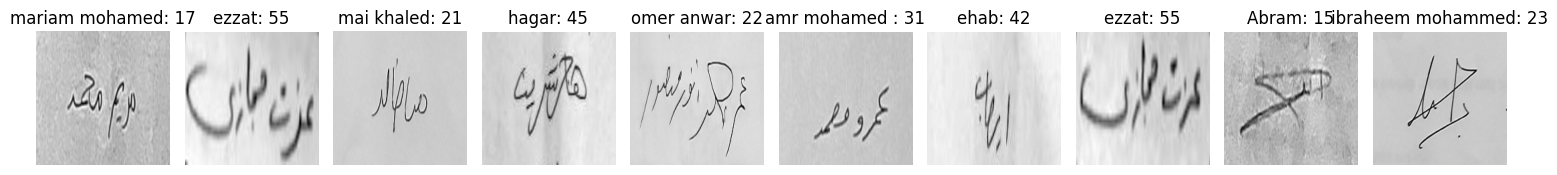

In [27]:
num_images_to_plot = 10
plt.figure(figsize=(15, 10))

for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)
    plt.imshow(X_train[i].reshape(new_width, new_height), cmap='gray')  # Reshape if needed (remove the channel dimension)
    plt.title(f"{user_dict[np.argmax(y_train[i])]}: {np.argmax(y_train[i])}")  # Display one-hot encoded label as text
    plt.axis('off')

plt.tight_layout()
plt.show()

### Summing across the 70 classes to get a one-dimensional array of labels

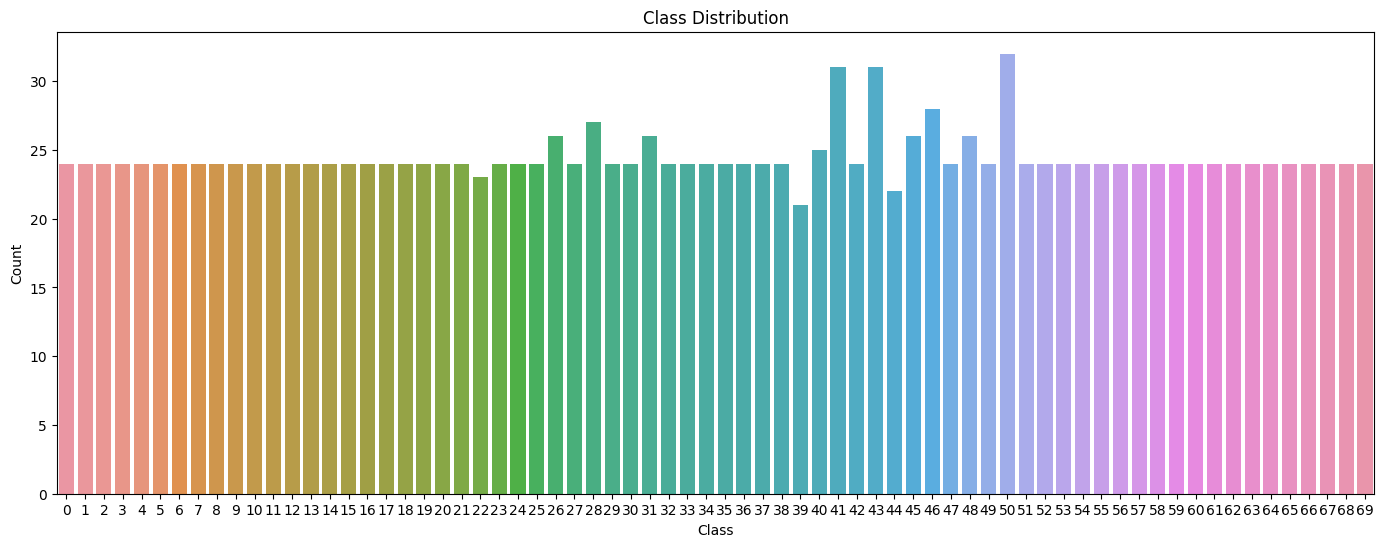

In [6]:
class_counts = np.sum(labels, axis=0)

plt.figure(figsize=(17, 6))
sns.barplot(x=np.arange(len(class_counts)), y=class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Calculate mean and standard deviation of images

In [7]:
mean_img = np.mean(data, axis=0)
std_img = np.std(data, axis=0)

print(f"Mean Image Pixel Value: {np.mean(mean_img)}")
print(f"Standard Deviation Image Pixel Value: {np.mean(std_img)}")

Mean Image Pixel Value: 155.32090473130845
Standard Deviation Image Pixel Value: 33.835996151765656


### Calculate pixel intensity histogram for a random image

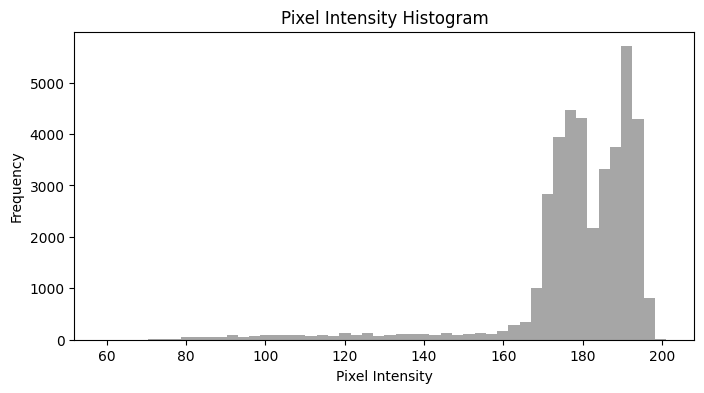

In [8]:
random_image_index = np.random.randint(0, len(data))
random_image = data[random_image_index]

plt.figure(figsize=(8, 4))
plt.hist(random_image.flatten(), bins=50, color='gray', alpha=0.7)
plt.title('Pixel Intensity Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

### Building an Alex Net Architicture for the classification task

In [9]:
def create_alexnet(input_shape, num_classes):
    model = Sequential()

    # Layer 1
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # Layer 2
    model.add(Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # Layer 3
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # Layer 4
    model.add(Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # Layer 5
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # Flatten and fully connected layers with dropout and L2 regularization
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

input_shape = (200, 200, 1)
num_classes = 70

# Create AlexNet model
alexnet_model = create_alexnet(input_shape, num_classes)

# Compile the model
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 23, 23, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 256)       0         
 g2D)                                                            
                                                        

### Training the model

Epoch 1/177
22/22 [==============================] - 72s 3s/step - loss: 2.4448 - accuracy: 0.9832 - val_loss: 3.2741 - val_accuracy: 0.8892
Epoch 2/177
22/22 [==============================] - 73s 3s/step - loss: 2.3026 - accuracy: 0.9803 - val_loss: 6.3223 - val_accuracy: 0.5219
Epoch 3/177
22/22 [==============================] - 73s 3s/step - loss: 2.2302 - accuracy: 0.9795 - val_loss: 3.2265 - val_accuracy: 0.8309
Epoch 4/177
22/22 [==============================] - 76s 3s/step - loss: 2.1489 - accuracy: 0.9832 - val_loss: 3.5896 - val_accuracy: 0.7405
Epoch 5/177
22/22 [==============================] - 76s 3s/step - loss: 2.1001 - accuracy: 0.9766 - val_loss: 3.2183 - val_accuracy: 0.8397
Epoch 6/177
22/22 [==============================] - 74s 3s/step - loss: 1.9621 - accuracy: 0.9869 - val_loss: 4.1045 - val_accuracy: 0.6472
Epoch 7/177
22/22 [==============================] - 75s 3s/step - loss: 1.8639 - accuracy: 0.9869 - val_loss: 2.5114 - val_accuracy: 0.9184
Epoch 8/177
2

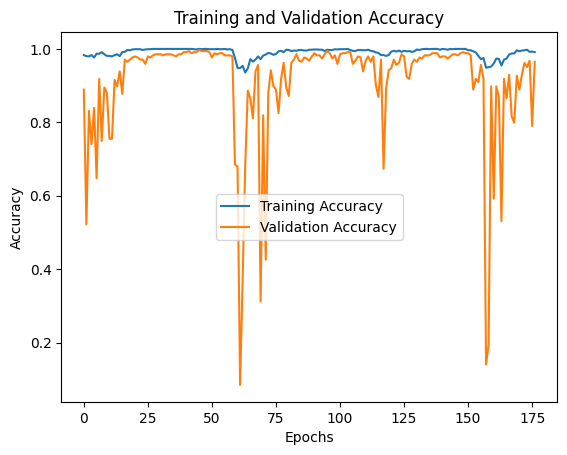

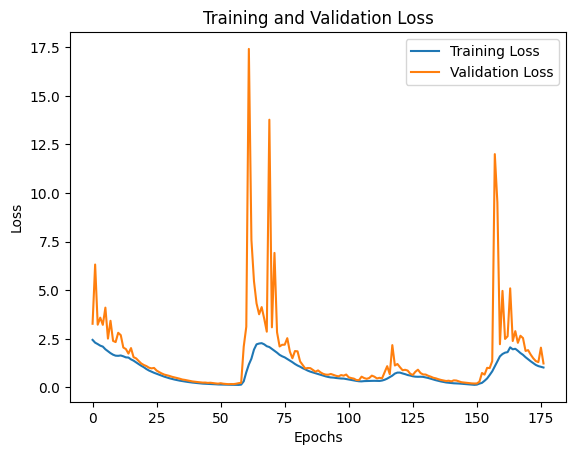

In [15]:
history = alexnet_model.fit(X_train, y_train, epochs=177, batch_size=64, validation_data=(X_val, y_val))


# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Savnig the model

In [19]:
import pickle

with open('alenet_177_arab_sig70.pkl', 'wb') as file:
    pickle.dump(alexnet_model, file)

### Create a download link for the model 

In [21]:
from IPython.display import FileLink

# Create a link to download the file
FileLink(r'alenet_177_arab_sig70.pkl')

/kaggle/working/alenet_177_arab_sig70.pkl

### Test with 4 images, their labels are [0, 1, 34, 42]

In [16]:
predictions = []

# for preprocessing and resizing
new_width = 200
new_height = 200

images = sorted(os.listdir('/kaggle/input/test-samples/test_samples'))

for image in (images):

    image_name = os.path.join('/kaggle/input/test-samples/test_samples', image)
    
    # Reading the image
    test_image = cv2.imread(image_name)

    # Convert to grayscale
    gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

    # Resize the image
    resized_image = cv2.resize(gray_image, (new_width, new_height))
    
    # Expand dimensions to create a batch of size 1
    resized_image = np.expand_dims(resized_image, axis=0)
    
    # Append the preprocessed image and its label
    prediction = alexnet_model.predict(resized_image)
    
    predictions.append(prediction)

# print(predictions)

1/1 [==============================] - 0s 51ms/step
[array([[9.93639171e-01, 1.87329897e-05, 2.77924642e-07, 2.33768318e-07,
        2.24621435e-05, 1.01347605e-05, 1.10749061e-05, 3.36778089e-06,
        1.88427677e-07, 1.53527685e-06, 1.47217293e-06, 9.88649163e-07,
        1.45874301e-05, 2.27016722e-06, 1.73759490e-05, 4.04853374e-03,
        1.06192338e-05, 8.23462642e-07, 4.35441649e-07, 1.03817802e-05,
        7.98310939e-05, 5.30717953e-04, 4.31738727e-07, 2.06591030e-05,
        2.36167921e-06, 5.67007337e-05, 1.19853403e-05, 5.14998865e-05,
        9.97812003e-06, 8.21462550e-07, 6.50199872e-05, 5.98968472e-06,
        4.15301656e-07, 3.46804009e-05, 1.27220728e-05, 1.35000028e-06,
        6.53705938e-05, 4.08558435e-06, 8.13323277e-06, 2.32123624e-04,
        4.67582595e-06, 1.96725250e-05, 2.79478445e-05, 3.67222628e-06,
        1.12518494e-04, 5.36697871e-06, 7.48449747e-05, 1.57371562e-06,
        5.02673720e-05, 1.78675182e-04, 7.28500527e-05, 2.82423844e-05,
        7.1

### Predicting the test samples

In [18]:
highest_propapilities = []
labels = []
user_names = []

for arr in predictions:
    arr = arr[0]             # Accessing the inner array
    max_value = np.max(arr)  # Find the maximum value in the array
    label = np.argmax(arr)   # Find the index of the maximum value
    highest_propapilities.append(max_value)
    labels.append(label)
    user_names.append(user_dict[label])

print("Highest values:", highest_propapilities)
print("Corresponding labels:", labels)
print("Corresponding users:", user_names)

Highest values: [0.9936392, 0.61852735, 0.9156312, 0.99609023]
Corresponding labels: [0, 1, 34, 15]
Corresponding users: ['amr', 'abdelrahman saeed', 'Belal', 'Abram']


### The model predicted 3 correctly and failed with the third one, reaching accuracy = 96.5%